# Data Vault Demo (Quant, can also score own portfolio)

The basic concept of the Data Vault is that when a user authenticates themself, they receive an engine that gives them access to all the data (rows, columns, tables, schema, etc.) for which they are authorized.  Users who can authenticate themselves for multiple roles can use those roles simultaneously.  We are keeping in mind the importance of Data Lineage Management (tracked by issue https://github.com/os-climate/os_c_data_commons/issues/50) but is not treated as part of this particular prototype.

The steps of this demo are:

1. **Authenticate and acquire SQLAlchemy engine**
    1. Dev engine sees all
    2. **Quant engine can do temp scoring but not see fundamental company info**
    3. User engine can use temp scoring but not see cumulative emissions nor overshoot info
2. With Dev engine, construct Vaults for:
    1. Fundamental corporate financial information
    2. Corporate emissions data (base year, historical)
    3. Corporate target data (start year, end year, target start value, target end value)
    4. Sector benchmark data (production, CO2e intensity)
3. Dev Engine: Visualize projected emissions (targets and trajectories) and calculate cumulative emissions
4. **Quant Engine: Using calculated cumulative emmisions, visualize per-company trajectory and target temperature scores**
5. User Engine: Using consensus probability scoring and own portfolio data (ISIN, position value)
    1. Calculate publishable per-company temperature alignment score
    2. Based on aggregate corporate and portfolio information, produce weighting scores to yield overall portfolio alignment score

In [1]:
import os
import pathlib
from dotenv import load_dotenv

# Load some standard environment variables from a dot-env file, if it exists.
# If no such file can be found, does not fail, and so allows these environment vars to
# be populated in some other way
dotenv_dir = os.environ.get('CREDENTIAL_DOTENV_DIR', os.environ.get('PWD', '/opt/app-root/src'))
dotenv_path = pathlib.Path(dotenv_dir) / 'credentials.env'
if os.path.exists(dotenv_path):
    load_dotenv(dotenv_path=dotenv_path,override=True)

import trino
from sqlalchemy.engine import create_engine

### The ITR module provides Vault objects that coordinate the interaction of Dev, Quant, and User roles.

The SQLAlchemy engines mediate the actual interaction with the Data Vault.

In [2]:
import json
import pandas as pd
from numpy.testing import assert_array_equal
import ITR

# from ITR.portfolio_aggregation import PortfolioAggregationMethod
# from ITR.temperature_score import TemperatureScore
# from ITR.configs import ColumnsConfig, TemperatureScoreConfig
# from ITR.data.data_warehouse import DataWarehouse
from ITR.data.vault_providers import VaultCompanyDataProvider, VaultProviderProductionBenchmark, \
    VaultProviderIntensityBenchmark, DataVaultWarehouse
# from ITR.interfaces import ICompanyData, EScope, ETimeFrames, PortfolioCompany, IEmissionIntensityBenchmarkScopes, \
#     IProductionBenchmarkScopes
from ITR.interfaces import EScope, IProductionBenchmarkScopes, IEmissionIntensityBenchmarkScopes

### Step 4: Use Quant engine to access and visualize temperature scores

When the Data Vault is ready to be implemented, we can demonstrate that the Quant engine does not have access to primary company data (neither financial nor production)

In [3]:
sqlstring = 'trino://{user}@{host}:{port}/'.format(
    user = os.environ['TRINO_USER_USER2'],
    host = os.environ['TRINO_HOST'],
    port = os.environ['TRINO_PORT']
)
sqlargs = {
    'auth': trino.auth.JWTAuthentication(os.environ['TRINO_PASSWD_USER2']),
    'http_scheme': 'https',
    'catalog': 'osc_datacommons_dev',
    'schema': 'demo',
}

ingest_catalog = 'osc_datacommons_dev'
ingest_schema = 'demo'

engine_quant = create_engine(sqlstring, connect_args = sqlargs)
print("connecting with engine " + str(engine_quant))
connection_quant = engine_quant.connect()

connecting with engine Engine(trino://os-climate-user2@trino-secure-odh-trino.apps.odh-cl1.apps.os-climate.org:443/)


Show that we *cannot* access fundamental company data (cannot show until op1st team changes permissions)

In [4]:
vault_company_data = VaultCompanyDataProvider (engine_quant,
                                               company_table='company_data',
                                               target_table=None,
                                               trajectory_table=None,
                                               company_schema='demo',
                                               column_config=None,
                                               tempscore_config=None)

In [5]:
vault_warehouse = DataVaultWarehouse(engine_quant,
                                     company_data=None,
                                     benchmark_projected_production=None,
                                     benchmarks_projected_emissions_intensity=None,
                                     ingest_schema = 'demo',
                                     column_config=None,
                                     tempscore_config=None)

vault_warehouse.quant_init(engine_quant, company_data=vault_company_data, ingest_schema='demo')

Show that we *can* access both cumulative emissions (input) and temperature scores (output)

In [6]:
temp_score_df = pd.read_sql_table(f"temperature_scores", engine_quant)

In [7]:
temp_score_df

,company_name,company_id,source,scope,benchmark,trajectory_temperature_score,target_temperature_score
0,"Hawaiian Electric Industries, Inc.",US4198701009,demo,S1+S2,benchmark_1,2.335098,1.763241
1,Northwestern Corp.,US6680743050,demo,S1+S2,benchmark_1,1.857969,1.662417
2,Sempra,US8168511090,demo,S1+S2,benchmark_1,1.384800,1.344634
3,Brookfield Asset Management,CA1125851040,demo,S1+S2,benchmark_1,1.262227,1.262227
4,Black Hills Corp.,US0921131092,demo,S1+S2,benchmark_1,2.205830,1.884104
5,"Xcel Energy, Inc.",US98389B1008,demo,S1+S2,benchmark_1,2.146173,1.587192
6,PPL Corp.,US69351T1060,demo,S1+S2,benchmark_1,3.255960,2.863050
7,Dominion Energy,US25746U1097,demo,S1+S2,benchmark_1,1.850402,1.636624
8,Algonquin Power & Utilities Corp.,US0158577090,demo,S1+S2,benchmark_1,1.262227,1.262227
9,TIMKENSTEEL CORP,US8873991033,demo,S1+S2,benchmark_1,1.308265,1.281435


In [8]:
plottable_df = temp_score_df[['company_name', 'trajectory_temperature_score', 'target_temperature_score']].sort_values('company_name').set_index('company_name').T

In [9]:
plottable_df

company_name,AES Corp.,"ALLETE, Inc.",Alcoa Corp.,Algonquin Power & Utilities Corp.,Alliant Energy,Ameren Corp.,"American Electric Power Co., Inc.","Avangrid, Inc.",Avista Corp.,Black Hills Corp.,...,Southern Co.,TC Energy Corp.,TENARIS SA,TIMKENSTEEL CORP,UNITED STATES STEEL CORP,Verso Corp.,Vistra Corp.,WEC Energy Group,WORTHINGTON INDUSTRIES INC,"Xcel Energy, Inc."
trajectory_temperature_score,2.351806,2.190575,1.262227,1.262227,2.170023,2.642690,2.482552,1.327895,1.262227,2.205830,...,2.328599,1.262227,1.317665,1.308265,1.623504,1.262227,1.262227,2.428914,1.267906,2.146173
target_temperature_score,1.860013,1.935872,1.262227,1.262227,1.804351,2.201277,2.053782,1.271416,1.262227,1.884104,...,2.170918,1.262227,1.317665,1.281435,1.445919,1.262227,1.262227,2.495716,1.267906,1.587192


<AxesSubplot:>

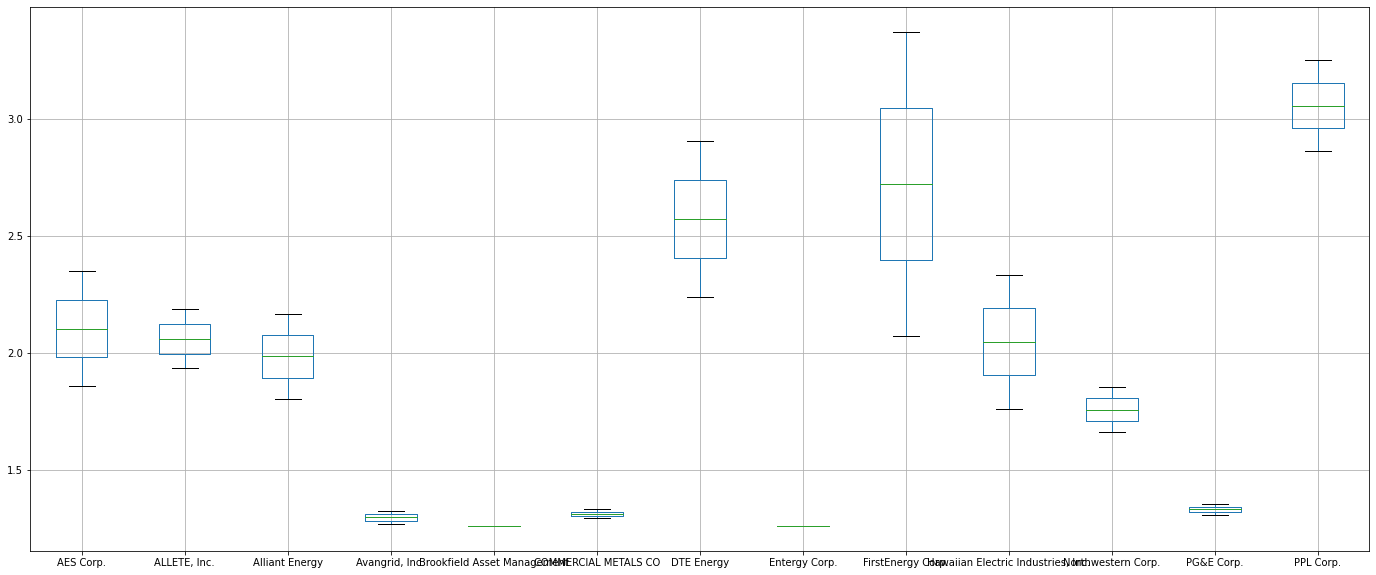

In [10]:
# Must plot the first few columns, but then plot 1/3rd of the companies so as not to over-clutter the graph
plottable_df.iloc[:, [x for x in list(range(0,2)) + list(range(4,35,3))]].boxplot(figsize=(24,10))

### Step 5: Show per-company temperature score and weighted portfolio alignment score

Portfolio weighting scores (which ultimately influence portfolio alignment score) include:
* WATS (size of portfolio company positions used as weights)
* TETS (size of total emissions of portfolio companies used as weights)
* Financial fundamental weights:
    * Market Cap
    * Enterprise Value
    * Assets
    * Revenues

We can pass a list of company IDs to the Data Vault to get back a sum without exposing granular data

Show that we *can also* access both cumulative emissions (input) and temperature scores (output)

In [11]:
# portfolio_df = pd.read_csv("data/mdt-20220116-portfolio.csv", encoding="iso-8859-1", sep=';', index_col='company_id')
portfolio_df = pd.read_csv("data/rmi_all.csv", encoding="iso-8859-1", sep=',', index_col='company_id')
portfolio_df

,company_name,company_lei,investment_value
company_id,,,
US00130H1059,AES Corp.,2NUNNB7D43COUIRE5295,50000
US0138721065,Alcoa Corp.,549300T12EZ1F6PWWU29,50000
US0158577090,Algonquin Power & Utilities Corp.,549300K5VIUTJXQL7X75,50000
US0185223007,"ALLETE, Inc.",549300NNLSIMY6Z8OT86,50000
US0188021085,Alliant Energy,5493009ML300G373MZ12,50000
...,...,...,...
NaN,Wells Rural Electric Co.,NaN,50000
NaN,Wellsboro Electric Co.,NaN,50000
NaN,"White River Electric Association, Inc.",NaN,50000


### Calculate portfolio alignment temperature score based on WATS

We can do this with information exclusive to the user space (and the probability-adjusted temperature scores)

Note that companies with no production information (such as TITAL INTERNATIONAL INC and UNIVERSAL STAINLESS & ALLOY PRODUCTS INC will show NaN (Not a Number) as a score.

In [12]:
# PA_SCORE means "Probability-Adjusted" Temperature Score
portfolio_df['pa_score'] = vault_warehouse.get_pa_temp_scores(probability=0.5, company_ids=portfolio_df.index.values)

In [13]:
# portfolio_df[portfolio_df.company_name=='POSCO']
portfolio_df.dropna(inplace=True)
portfolio_df.sort_values(by='company_name')

,company_name,company_lei,investment_value,pa_score
company_id,,,,
US00130H1059,AES Corp.,2NUNNB7D43COUIRE5295,50000,2.105909
US0185223007,"ALLETE, Inc.",549300NNLSIMY6Z8OT86,50000,2.063224
US0138721065,Alcoa Corp.,549300T12EZ1F6PWWU29,50000,1.262227
US0158577090,Algonquin Power & Utilities Corp.,549300K5VIUTJXQL7X75,50000,1.262227
US0188021085,Alliant Energy,5493009ML300G373MZ12,50000,1.987187
US0236081024,Ameren Corp.,XRZQ5S7HYJFPHJ78L959,50000,2.421983
US0255371017,"American Electric Power Co., Inc.",1B4S6S7G0TW5EE83BO58,50000,2.268167
US05351W1036,"Avangrid, Inc.",549300OX0Q38NLSKPB49,50000,1.299655
US05379B1070,Avista Corp.,Q0IK63NITJD6RJ47SW96,50000,1.262227


In [14]:
weight_for_WATS = portfolio_df['investment_value'].sum()
weight_for_WATS

1950000

In [15]:
portfolio_df['WATS_weight'] = portfolio_df['pa_score'] * (portfolio_df['investment_value'] / weight_for_WATS)
portfolio_df.head()

,company_name,company_lei,investment_value,pa_score,WATS_weight
company_id,,,,,
US00130H1059,AES Corp.,2NUNNB7D43COUIRE5295,50000,2.105909,0.053998
US0138721065,Alcoa Corp.,549300T12EZ1F6PWWU29,50000,1.262227,0.032365
US0158577090,Algonquin Power & Utilities Corp.,549300K5VIUTJXQL7X75,50000,1.262227,0.032365
US0185223007,"ALLETE, Inc.",549300NNLSIMY6Z8OT86,50000,2.063224,0.052903
US0188021085,Alliant Energy,5493009ML300G373MZ12,50000,1.987187,0.050954


In [16]:
print(f"Portfolio temperature score based on WATS = {portfolio_df['WATS_weight'].sum()}")

Portfolio temperature score based on WATS = 1.8719702807465801


### Calculate portfolio alignment temperature score based on TETS

We need to carefully meld portfolio data with corp fundamental data (in this case, emissions)

In [17]:
portfolio_df['TETS_weight'] = vault_company_data.compute_portfolio_weights(portfolio_df['pa_score'], 2019, 'emissions', EScope.S1S2)
portfolio_df.head()

,company_name,company_lei,investment_value,pa_score,WATS_weight,TETS_weight
company_id,,,,,,
US00130H1059,AES Corp.,2NUNNB7D43COUIRE5295,50000,2.105909,0.053998,0.043264
US0138721065,Alcoa Corp.,549300T12EZ1F6PWWU29,50000,1.262227,0.032365,0.000000
US0158577090,Algonquin Power & Utilities Corp.,549300K5VIUTJXQL7X75,50000,1.262227,0.032365,0.007193
US0185223007,"ALLETE, Inc.",549300NNLSIMY6Z8OT86,50000,2.063224,0.052903,0.015489
US0188021085,Alliant Energy,5493009ML300G373MZ12,50000,1.987187,0.050954,0.037716


In [18]:
print(f"Portfolio temperature score based on TETS = {portfolio_df['TETS_weight'].sum()}")

Portfolio temperature score based on TETS = 2.0995755688941156


### Calculate portfolio alignment temperature score based on MOTS, EOTS, ECOTS, AOTS, and ROTS

* MOTS = market cap weights
* EOTS = enterprise value weights
* ECOTS = EVIC weights
* AOTS = asset weights
* ROTS = revenue weights

In [19]:
weighting_dict = {
    'MOTS': 'company_market_cap',
    'EOTS': 'company_enterprise_value',
    'ECOTS': 'company_evic',
    'AOTS': 'company_total_assets',
    'ROTS': 'company_revenue',
}

for k, v in weighting_dict.items():
    weight_column = f"{k}_weight"
    portfolio_df[weight_column] = vault_company_data.compute_portfolio_weights(portfolio_df['pa_score'], 2019, v, EScope.S1S2)
    print(f"Portfolio temperature score based on {k} = {portfolio_df[weight_column].sum()}")

portfolio_df

Portfolio temperature score based on MOTS = 1.9553783519299202
Portfolio temperature score based on EOTS = 1.9642265800595662
Portfolio temperature score based on ECOTS = 1.9535230492185478
Portfolio temperature score based on AOTS = 1.7668105855433356
Portfolio temperature score based on ROTS = 1.7662923761353264


,company_name,company_lei,investment_value,pa_score,WATS_weight,TETS_weight,MOTS_weight,EOTS_weight,ECOTS_weight,AOTS_weight,ROTS_weight
company_id,,,,,,,,,,,
US00130H1059,AES Corp.,2NUNNB7D43COUIRE5295,50000,2.105909,0.053998,4.326361e-02,0.030532,0.019073,0.035616,0.038141,0.055800
US0138721065,Alcoa Corp.,549300T12EZ1F6PWWU29,50000,1.262227,0.032365,0.000000e+00,0.004080,0.003992,0.006086,0.009940,0.034246
US0158577090,Algonquin Power & Utilities Corp.,549300K5VIUTJXQL7X75,50000,1.262227,0.032365,7.193075e-03,NaN,NaN,NaN,0.007420,0.005339
US0185223007,"ALLETE, Inc.",549300NNLSIMY6Z8OT86,50000,2.063224,0.052903,1.548850e-02,0.008971,0.009437,0.009666,0.006089,0.006656
US0188021085,Alliant Energy,5493009ML300G373MZ12,50000,1.987187,0.050954,3.771644e-02,0.036396,0.039115,0.038327,0.017864,0.018852
US0236081024,Ameren Corp.,XRZQ5S7HYJFPHJ78L959,50000,2.421983,0.062102,9.710672e-02,0.064485,0.066420,0.067878,0.037719,0.037224
US0255371017,"American Electric Power Co., Inc.",1B4S6S7G0TW5EE83BO58,50000,2.268167,0.058158,2.332623e-01,0.138065,0.164953,0.146101,0.092655,0.091788
US05351W1036,"Avangrid, Inc.",549300OX0Q38NLSKPB49,50000,1.299655,0.033324,5.779251e-05,0.004749,0.014100,0.005368,0.024061,0.021414
US05379B1070,Avista Corp.,Q0IK63NITJD6RJ47SW96,50000,1.262227,0.032365,5.288110e-03,0.004801,0.005867,0.005069,0.004132,0.004417


### Companies for which we lack production data (and thus cannot chart)

In [20]:
portfolio_df[portfolio_df.pa_score.isnull()]

,company_name,company_lei,investment_value,pa_score,WATS_weight,TETS_weight,MOTS_weight,EOTS_weight,ECOTS_weight,AOTS_weight,ROTS_weight
company_id,,,,,,,,,,,


In [21]:
engine_quant.execute("select * from demo.company_data").fetchall()

[('AES Corp.', '2NUNNB7D43COUIRE5295', 'US00130H1059', 4010, 2019, 'US', 'North America', 10189000000.0, 9420000000.0, 8652000000, 33648000000.0, 1029000000.0),
 ('ALLETE, Inc.', '549300NNLSIMY6Z8OT86', 'US0185223007', 4010, 2019, 'US', 'North America', 1240500000.0, 2825208722.0, 4369708722, 5482800000.0, 69300000.0),
 ('Alcoa Corp.', '549300T12EZ1F6PWWU29', 'US0138721065', 4010, 2019, 'US', 'North America', 10433000000.0, 2100000000.0, 3021000000, 14631000000.0, 879000000.0),
 ('American States Water Co.', '529900L26LIS2V8PWM23', 'US0298991011', 4010, 2019, 'US', 'North America', 473869000.0, 2900179000.0, 3183544000, 1641331000.0, 1334000.0),
 ('Avangrid, Inc.', '549300OX0Q38NLSKPB49', 'US05351W1036', 4010, 2019, 'US', 'North America', 6336000000.0, 2374000000.0, 10364000000, 34394000000.0, 178000000.0),
 ('Avista Corp.', 'Q0IK63NITJD6RJ47SW96', 'US05379B1070', 4010, 2019, 'US', 'North America', 1345622000.0, 2471363713.0, 4440667713, 6082456000.0, 9896000.0),
 ('Black Hills Corp.',